# 🧠 Clasificador de Ropa usando Redes Neuronales
Este notebook muestra paso a paso cómo entrenar un modelo para clasificar prendas de ropa a partir de imágenes, usando `PyTorch`.

## 📦 Instalación automática de librerías
Este bloque asegura que todas las dependencias estén presentes.

In [1]:
import os
import torch
import shutil
import numpy as np
from glob import glob
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms as T

torch.manual_seed(2024)



###  DatasetPrendas

Define un dataset personalizado para cargar imágenes desde carpetas, donde cada subcarpeta representa una clase.

- Lee rutas de imágenes `.jpg`.
- Asigna un índice a cada clase.
- Aplica transformaciones si se indican.
- Devuelve tuplas `(imagen, etiqueta)` listas para entrenamiento.


In [3]:
class DatasetPrendas(Dataset):
    
    def __init__(self, carpeta, transformaciones=None):
        self.transformaciones = transformaciones
        self.rutas_imagenes = sorted(glob(os.path.join(carpeta, "*", "*.jpg")))

        if len(self.rutas_imagenes) == 0:
            raise ValueError(f"No se encontraron imágenes en {carpeta}")
        
        self.etiquetas = {}
        self.cantidad_por_clase = {}
        contador = 0

        for ruta in self.rutas_imagenes:
            clase = self.obtener_clase(ruta)
            if clase not in self.etiquetas:
                self.etiquetas[clase] = contador
                self.cantidad_por_clase[clase] = 1
                contador += 1
            else:
                self.cantidad_por_clase[clase] += 1

    def obtener_clase(self, ruta):
        return os.path.basename(os.path.dirname(ruta))

    def __len__(self):
        return len(self.rutas_imagenes)

    def __getitem__(self, indice):
        ruta = self.rutas_imagenes[indice]
        imagen = Image.open(ruta).convert("RGB")
        etiqueta = self.etiquetas[self.obtener_clase(ruta)]

        if self.transformaciones:
            imagen = self.transformaciones(imagen)
        
        return imagen, etiqueta


###  preparar_dataloaders

Función que divide el dataset en entrenamiento, validación y prueba, y devuelve los DataLoaders correspondientes.

- Separa los datos según proporciones definidas.
- Aplica una semilla fija para reproducibilidad.
- Devuelve los `DataLoader` listos para usar y el diccionario de clases.


In [4]:
def preparar_dataloaders(carpeta, transformaciones, batch_size=16, particion=[0.7, 0.15, 0.15], workers=2):
    
    dataset_completo = DatasetPrendas(carpeta, transformaciones)
    total = len(dataset_completo)
    
    if total < 3:
        raise ValueError("El dataset es demasiado pequeño para dividir.")
    
    largo_train = max(1, int(total * particion[0]))
    largo_val = max(1, int(total * particion[1]))
    largo_test = total - (largo_train + largo_val)

    while largo_train + largo_val + largo_test > total:
        if largo_train > 1: largo_train -= 1
        elif largo_val > 1: largo_val -= 1

    print(f"Datos divididos: Entrenamiento={largo_train}, Validación={largo_val}, Prueba={largo_test}")
    
    datos_entrenamiento, datos_validacion, datos_prueba = random_split(
        dataset_completo, lengths=[largo_train, largo_val, largo_test], generator=torch.Generator().manual_seed(42)
    )

    loader_entrenamiento = DataLoader(datos_entrenamiento, batch_size=min(batch_size, largo_train), shuffle=True, num_workers=workers)
    loader_validacion = DataLoader(datos_validacion, batch_size=min(batch_size, largo_val), shuffle=False, num_workers=workers)
    loader_prueba = DataLoader(datos_prueba, batch_size=1, shuffle=False, num_workers=workers)

    return loader_entrenamiento, loader_validacion, loader_prueba, dataset_completo.etiquetas


###  Búsqueda del Dataset

Verifica si el dataset está disponible en la ruta por defecto. Si no, intenta encontrarlo en rutas alternativas.

- Actualiza la variable `directorio_datos` con la ruta válida.
- Muestra un mensaje si no se encuentra el dataset.


In [5]:
directorio_datos = "./Clothes_Dataset"

if not os.path.exists(directorio_datos):
    posibles = [
        "./Clothes_Dataset",
        "../Clothes_Dataset",
        r"C:\Users\ricar\OneDrive\Documentos\deep\Clothes_Dataset"
    ]
    for ruta in posibles:
        if os.path.exists(ruta):
            directorio_datos = ruta
            print(f"📍 Dataset encontrado en: {ruta}")
            break
    else:
        print("❌ No se encontró el dataset.")
        print("📁 Contenido actual:", os.listdir('.'))


###  Preparación de transformaciones y carga de datos

- Define transformaciones de imagen: redimensionado, conversión a tensor y normalización.
- Llama a `preparar_dataloaders` para cargar los datos y dividirlos en entrenamiento, validación y prueba.
- Muestra información sobre la cantidad de batches y clases detectadas.


In [6]:
media_rgb = [0.485, 0.456, 0.406]
std_rgb = [0.229, 0.224, 0.225]
dimension = 224

transformacion = T.Compose([
    T.Resize((dimension, dimension)),
    T.ToTensor(),
    T.Normalize(mean=media_rgb, std=std_rgb)
])

try:
    dl_train, dl_val, dl_test, clases_detectadas = preparar_dataloaders(
        carpeta=directorio_datos,
        transformaciones=transformacion,
        batch_size=16,
        workers=0
    )

    print(f"🔢 Batches entrenamiento: {len(dl_train)}")
    print(f"🧪 Batches validación: {len(dl_val)}")
    print(f"🎯 Batches prueba: {len(dl_test)}")
    print(f"🏷️ Clases detectadas: {clases_detectadas}")
except Exception as error:
    print(f"⚠️ Error al preparar datos: {str(error)}")


Datos divididos: Entrenamiento=5250, Validación=1125, Prueba=1125
🔢 Batches entrenamiento: 329
🧪 Batches validación: 71
🎯 Batches prueba: 1125
🏷️ Clases detectadas: {'Blazer': 0, 'Celana_Panjang': 1, 'Celana_Pendek': 2, 'Gaun': 3, 'Hoodie': 4, 'Jaket': 5, 'Jaket_Denim': 6, 'Jaket_Olahraga': 7, 'Jeans': 8, 'Kaos': 9, 'Kemeja': 10, 'Mantel': 11, 'Polo': 12, 'Rok': 13, 'Sweter': 14}


In [7]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'


In [8]:
import matplotlib.pyplot as plt
import random


### analizar_dataset

Analiza la distribución de clases en el dataset.

- Muestra un gráfico de barras con la cantidad de imágenes por clase.
- Si hay muchas clases, selecciona las más y menos frecuentes.
- Imprime estadísticas: total de imágenes, promedio por clase, clase más y menos frecuente, y desviación estándar.


In [20]:
def analizar_dataset(ruta, transformaciones=None):
    from numpy import argsort, std, argmax, argmin
    import gc

    try:
        dataset_analisis = DatasetPrendas(ruta, transformaciones=None)
        clases_conteo = dataset_analisis.cantidad_por_clase

        nombres_clases = list(clases_conteo.keys())
        cantidades = list(clases_conteo.values())

        # Limitar a un máximo de clases para el gráfico
        max_clases = 15
        if len(cantidades) > max_clases:
            print(f"📉 Demasiadas clases para un gráfico claro. Mostrando las {max_clases} más frecuentes.")
            indices_ordenados = argsort(cantidades)[::-1][:max_clases]
            nombres_clases = [nombres_clases[i] for i in indices_ordenados]
            cantidades = [cantidades[i] for i in indices_ordenados]

        # Gráfico de pastel
        plt.figure(figsize=(8, 8))
        plt.pie(cantidades, labels=nombres_clases, autopct='%1.1f%%', startangle=140, 
                textprops={'fontsize': 9})
        plt.title("Distribución de Clases en el Dataset (Gráfico de Pastel)", fontsize=14)
        plt.tight_layout()
        plt.show()
        plt.close()

        # Estadísticas adicionales
        total = sum(clases_conteo.values())
        media = total / len(clases_conteo)
        print(f"📈 Total de imágenes: {total}")
        print(f"📊 Promedio por clase: {media:.1f}")
        print(f"🔝 Clase más frecuente: {max(clases_conteo, key=clases_conteo.get)} ({max(cantidades)})")
        print(f"🔻 Clase menos frecuente: {min(clases_conteo, key=clases_conteo.get)} ({min(cantidades)})")
        print(f"📉 Desviación estándar: {std(list(clases_conteo.values())):.2f} (mayor = más desbalance)")

    except Exception as error:
        print(f"⚠️ Ocurrió un error en el análisis: {str(error)}")
        import traceback
        traceback.print_exc()
    finally:
        gc.collect()


###  convertir_tensor_a_imagen

Convierte un tensor normalizado (usado para entrenamiento) en una imagen tipo `numpy` para poder visualizarla.

- Revierte la normalización aplicada (RGB o escala de grises).
- Retorna una imagen en formato `uint8` lista para mostrar con `matplotlib`.


In [22]:
def convertir_tensor_a_imagen(tensor, tipo="rgb"):
    """
    Transforma un tensor normalizado a una imagen en formato numpy para visualizar.
    """
    if tipo == "gray":
        inversa = T.Compose([
            T.Normalize(mean=[0.], std=[1/0.5]),
            T.Normalize(mean=[-0.5], std=[1.])
        ])
    else:
        inversa = T.Compose([
            T.Normalize(mean=[0., 0., 0.], std=[1/0.229, 1/0.224, 1/0.225]),
            T.Normalize(mean=[-0.485, -0.456, -0.406], std=[1., 1., 1.])
        ])

    imagen = inversa(tensor) * 255
    imagen = imagen.detach().cpu()

    if tipo == "gray":
        imagen = imagen.squeeze().permute(1, 2, 0).numpy().astype(np.uint8)
    else:
        imagen = imagen.permute(1, 2, 0).numpy().astype(np.uint8)

    return imagen


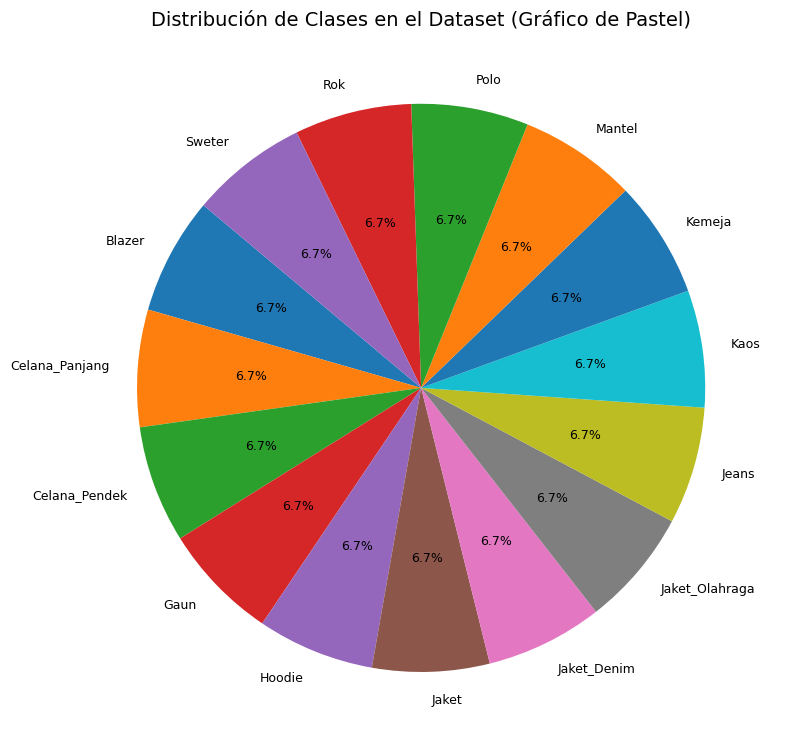

📈 Total de imágenes: 7500
📊 Promedio por clase: 500.0
🔝 Clase más frecuente: Blazer (500)
🔻 Clase menos frecuente: Blazer (500)
📉 Desviación estándar: 0.00 (mayor = más desbalance)


In [24]:
try:
    analizar_dataset(ruta=directorio_datos, transformaciones=None)
except Exception as error:
    print(f"Error al ejecutar el análisis: {error}")
    print(f"Revisando existencia del directorio: {directorio_datos}")
    if os.path.exists(directorio_datos):
        print("📁 Carpetas disponibles:", os.listdir(directorio_datos))
    else:
        print("❌ Ruta no encontrada.")


In [23]:
def mostrar_imagenes(dataset, cantidad=12, filas=3, tipo_color="rgb", etiquetas=None):
    """
    Muestra una grilla de imágenes aleatorias con sus clases reales.
    """
    assert tipo_color in ["rgb", "gray"], "Debes especificar si la imagen es 'rgb' o 'gray'."

    if tipo_color == "rgb":
        mapa_color = "viridis"
    else:
        mapa_color = None

    indices_random = [random.randint(0, len(dataset) - 1) for _ in range(cantidad)]

    plt.figure(figsize=(20, 10))
    for i, idx in enumerate(indices_random):
        imagen, etiqueta = dataset[idx]
        plt.subplot(filas, cantidad // filas, i + 1)
        plt.imshow(convertir_tensor_a_imagen(imagen, tipo_color), cmap=mapa_color)
        plt.axis("off")
        if etiquetas:
            plt.title(f"Clase: {etiquetas[int(etiqueta)]}")
        else:
            plt.title(f"Etiqueta: {etiqueta}")

    plt.tight_layout()
    plt.show()


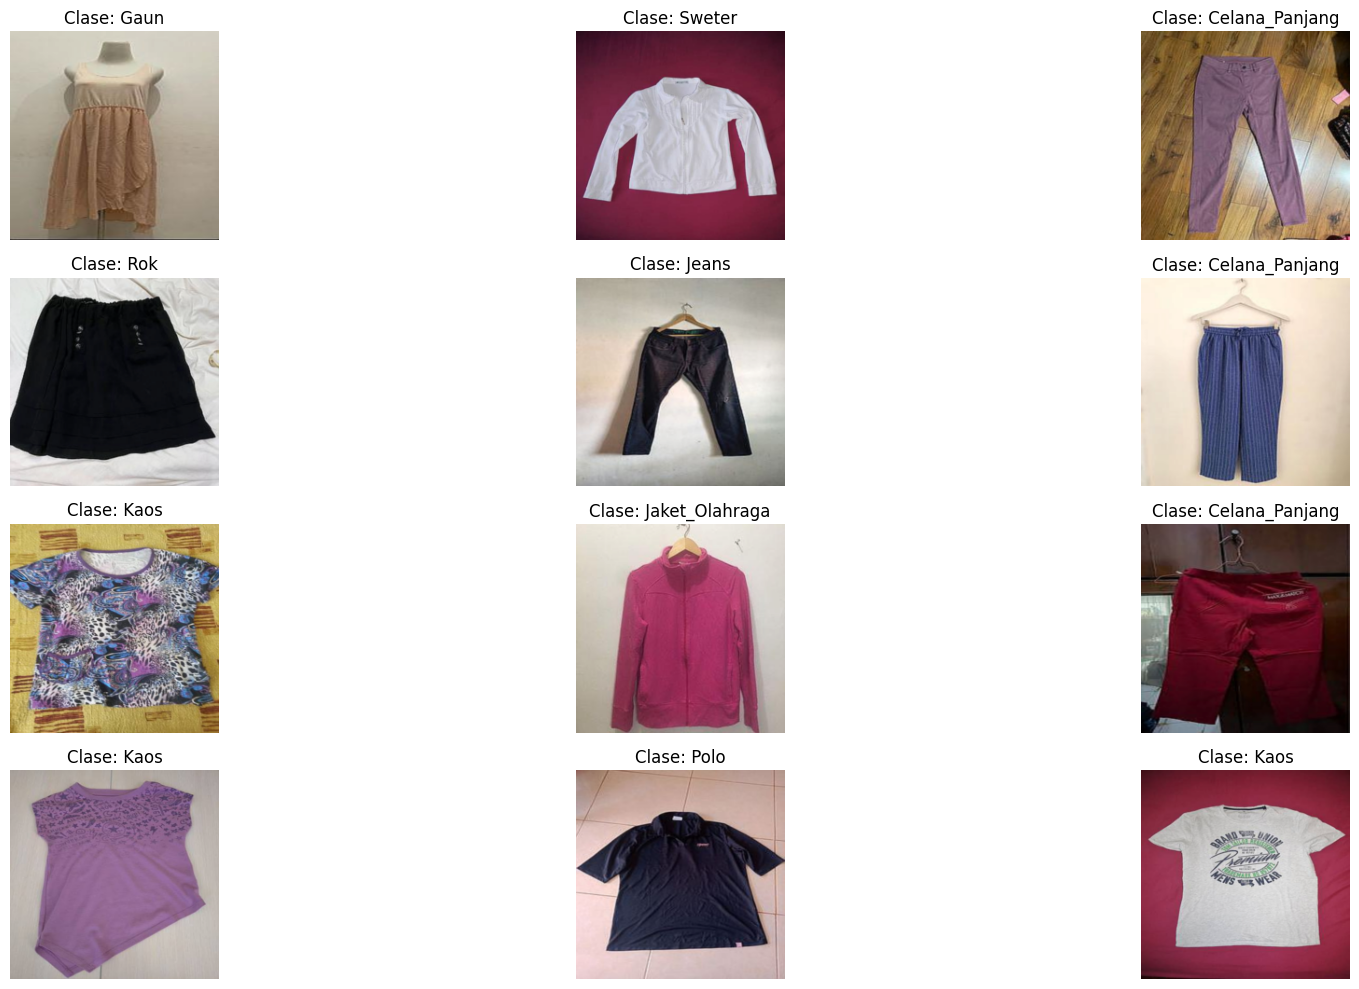

In [18]:
mostrar_imagenes(dl_train.dataset, cantidad=12, filas=4, tipo_color="rgb", etiquetas=list(clases_detectadas.keys()))


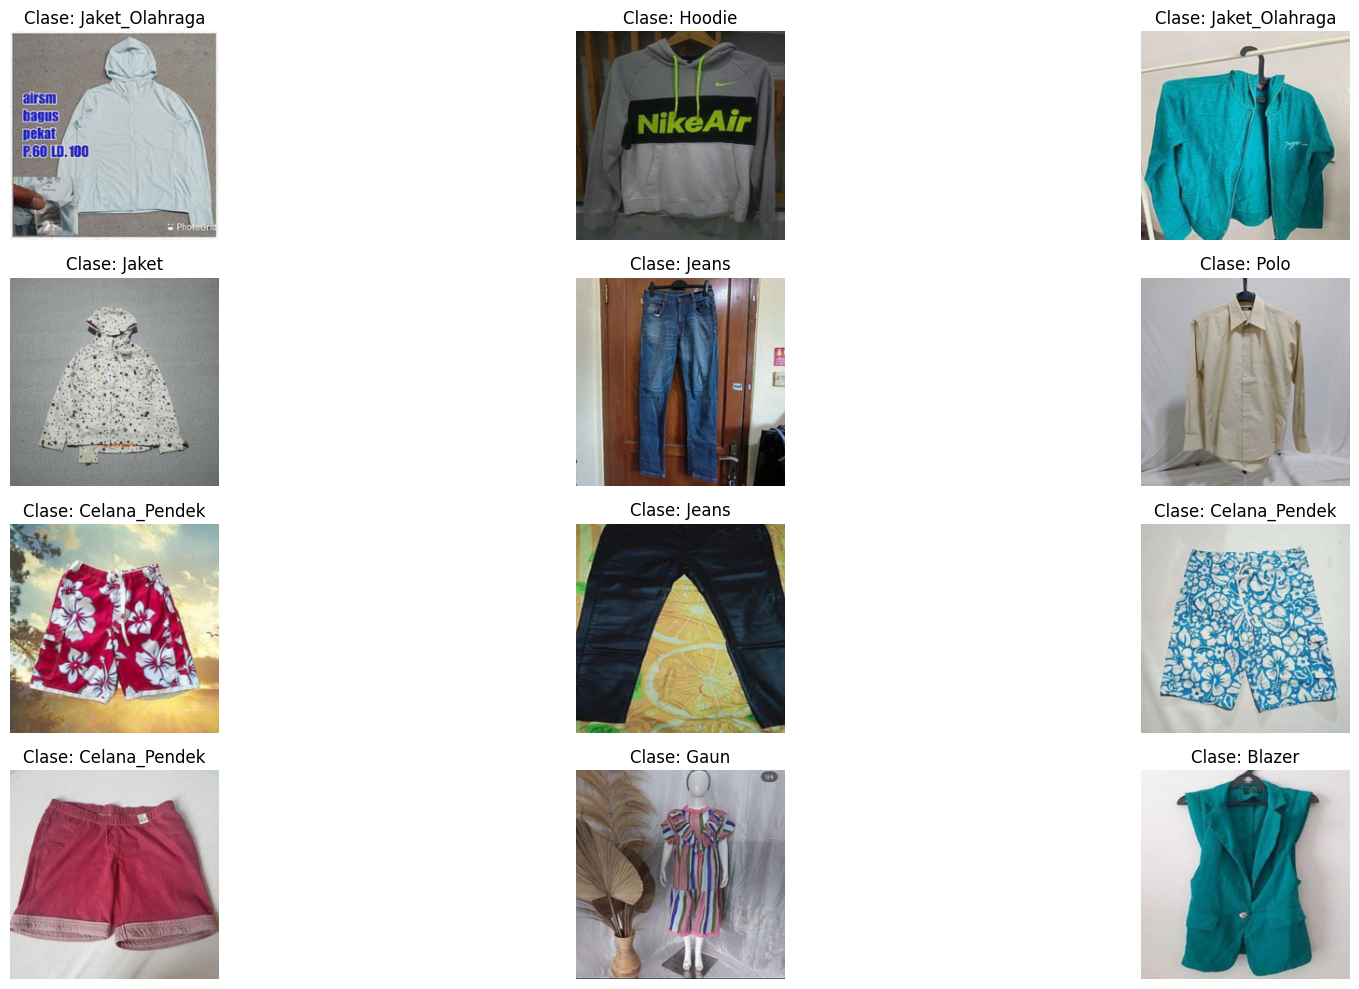

In [17]:
mostrar_imagenes(dl_val.dataset, cantidad=12, filas=4, tipo_color="rgb", etiquetas=list(clases_detectadas.keys()))


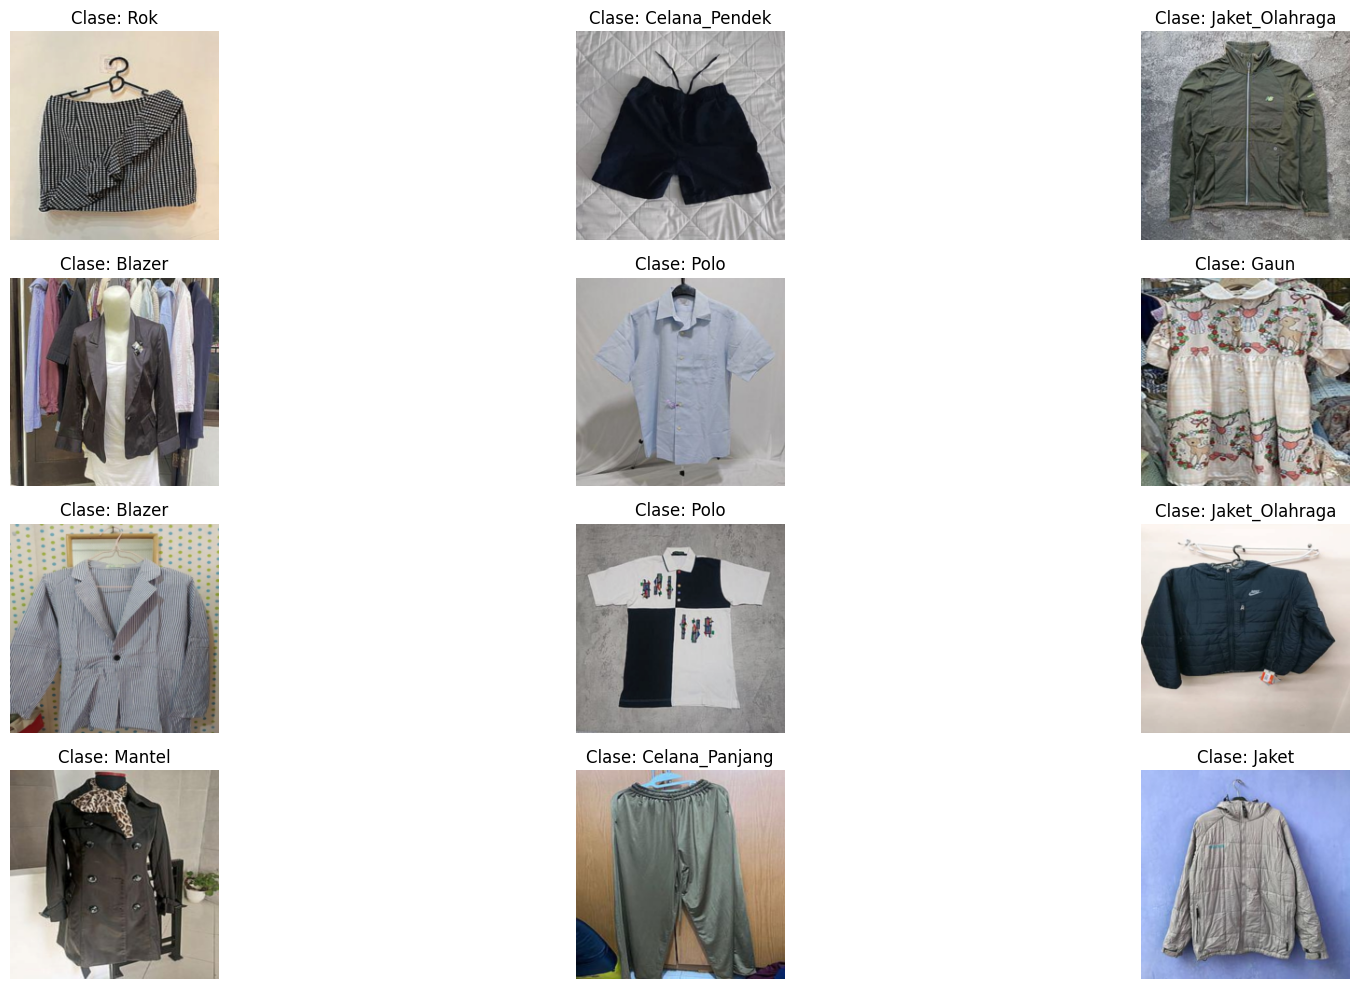

In [16]:
mostrar_imagenes(dl_test.dataset, cantidad=12, filas=4, tipo_color="rgb", etiquetas=list(clases_detectadas.keys()))


###  instalar_libreria

Verifica e instala automáticamente las librerías necesarias (`timm`, `torchmetrics`, `tqdm`) si no están disponibles.

- Usa `subprocess` para ejecutar `pip install`.
- Evita errores por dependencias faltantes en el entorno.


In [25]:
import sys, os, subprocess
import torch
import numpy as np

def instalar_libreria(nombre):
    try:
        __import__(nombre)
    except ImportError:
        print(f"📦 Instalando {nombre}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", nombre, "--quiet"])

for paquete in ["timm", "torchmetrics", "tqdm"]:
    instalar_libreria(paquete)


c:\Users\ricar\OneDrive\Documentos\deep\env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


###  Creación del modelo

Importa las librerías necesarias y crea un modelo `rexnet_150` preentrenado usando `timm`.

- Se ajusta el número de clases detectadas en el dataset.
- El modelo está listo para entrenamiento o evaluación.


In [26]:
import timm
import torchmetrics
from tqdm import tqdm

modelo = timm.create_model("rexnet_150", pretrained=True, num_classes=len(clases_detectadas))


###  Funciones de configuración y métricas

- **configurar_entrenamiento**: define dispositivo, función de pérdida, optimizador y número de épocas.
- **pasar_a_dispositivo**: mueve imágenes y etiquetas al dispositivo (CPU o GPU).
- **calcular_metricas**: calcula la pérdida, precisión y F1-score acumuladas durante entrenamiento o validación.


In [27]:
def configurar_entrenamiento(modelo):
    dispositivo = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"🚀 Usando {dispositivo} para entrenamiento")
    return (
        modelo.to(dispositivo),
        10,  # número de épocas
        dispositivo,
        torch.nn.CrossEntropyLoss(),
        torch.optim.Adam(params=modelo.parameters(), lr=3e-4)
    )

def pasar_a_dispositivo(lote, dispositivo):
    return lote[0].to(dispositivo), lote[1].to(dispositivo)

def calcular_metricas(modelo, imagenes, etiquetas, funcion_perdida, acum_loss, acum_acc, acum_f1):
    predicciones = modelo(imagenes)
    loss = funcion_perdida(predicciones, etiquetas)
    return (
        loss,
        acum_loss + loss.item(),
        acum_acc + (torch.argmax(predicciones, dim=1) == etiquetas).sum().item(),
        acum_f1 + f1_score(predicciones, etiquetas)
    )


###  Inicialización del entrenamiento 

- Se configura el modelo, dispositivo, función de pérdida y optimizador.
- Se define la métrica F1-score para clasificación multiclase.
- Se establece una ruta directa (`"./modelo_final.pth"`) para guardar el mejor modelo sin crear carpetas adicionales.


In [28]:
# Configurar modelo y parámetros
modelo, num_epocas, dispositivo, funcion_perdida, optimizador = configurar_entrenamiento(modelo)

# Definir métrica F1-score
f1_score = torchmetrics.F1Score(task="multiclass", num_classes=len(clases_detectadas)).to(dispositivo)

# Ruta directa para guardar el mejor modelo
ruta_modelo = "./modelo_final.pth"

print("🏁 Comenzando entrenamiento...")



🚀 Usando cuda para entrenamiento
🏁 Comenzando entrenamiento...


###  Inicialización de métricas y early stopping

- Se definen variables para controlar el guardado del mejor modelo (`mejor_loss`, `no_mejora`, `paciencia`, `umbral`).
- Se crean diccionarios para registrar las métricas de entrenamiento y validación: pérdida, precisión y F1-score.


In [29]:
mejor_loss = float("inf")
no_mejora = 0
paciencia = 5
umbral = 0.01

registros_entrenamiento = {"loss": [], "acc": [], "f1": []}
registros_validacion = {"loss": [], "acc": [], "f1": []}


###  Bucle de entrenamiento con validación y early stopping

- Ejecuta múltiples épocas de entrenamiento y validación del modelo.
- Calcula y guarda métricas (loss, accuracy, F1-score) en cada época.
- Guarda automáticamente el mejor modelo en `modelo_final.pth` cuando mejora la pérdida de validación.
- Implementa early stopping si no hay mejora durante varias épocas consecutivas.


In [31]:
mejor_loss = float("inf")  # Inicialización

ruta_modelo = "./modelo_final.pth"  # 🔒 Ruta personalizada donde se guardará el mejor modelo
no_mejora = 0
paciencia = 5

try:
    for epoca in range(num_epocas):
        modelo.train()
        total_loss, total_acc, total_f1 = 0, 0, 0

        for batch in tqdm(dl_train, desc=f"Época {epoca+1}/{num_epocas} [Entrenamiento]"):
            imgs, etiquetas = pasar_a_dispositivo(batch, dispositivo)
            loss, total_loss, total_acc, total_f1 = calcular_metricas(
                modelo, imgs, etiquetas, funcion_perdida, total_loss, total_acc, total_f1
            )
            optimizador.zero_grad()
            loss.backward()
            optimizador.step()

        # Métricas entrenamiento
        l = total_loss / len(dl_train)
        a = total_acc / len(dl_train.dataset)
        f = total_f1 / len(dl_train)
        registros_entrenamiento["loss"].append(l)
        registros_entrenamiento["acc"].append(a)
        registros_entrenamiento["f1"].append(f)

        print(f"✅ Epoch {epoca+1} - Loss: {l:.3f} | Acc: {a:.3f} | F1: {f:.3f}")

        # VALIDACIÓN
        modelo.eval()
        with torch.no_grad():
            val_loss, val_acc, val_f1 = 0, 0, 0
            for batch in dl_val:
                imgs, etiquetas = pasar_a_dispositivo(batch, dispositivo)
                loss, val_loss, val_acc, val_f1 = calcular_metricas(
                    modelo, imgs, etiquetas, funcion_perdida, val_loss, val_acc, val_f1
                )

        # Métricas validación
        lv = val_loss / len(dl_val)
        av = val_acc / len(dl_val.dataset)
        fv = val_f1 / len(dl_val)
        registros_validacion["loss"].append(lv)
        registros_validacion["acc"].append(av)
        registros_validacion["f1"].append(fv)

        print(f"🧪 Validación Epoch {epoca+1} - Loss: {lv:.3f} | Acc: {av:.3f} | F1: {fv:.3f}")

        # ✅ GUARDAR MEJOR MODELO
        if lv < mejor_loss:
            torch.save(modelo.state_dict(), ruta_modelo)
            mejor_loss = lv
            no_mejora = 0
            print(f"💾 Mejor modelo guardado en: {ruta_modelo} con loss: {lv:.3f}")
        else:
            no_mejora += 1
            print(f"⏸️ Sin mejora en {no_mejora} épocas consecutivas")
            if no_mejora >= paciencia:
                print("🛑 Deteniendo entrenamiento por early stopping")
                break

except Exception as error:
    print(f"❌ Error durante entrenamiento: {error}")
    import traceback
    traceback.print_exc()

print("✅ Entrenamiento finalizado")


Época 1/10 [Entrenamiento]: 100%|██████████| 329/329 [01:28<00:00,  3.71it/s]


✅ Epoch 1 - Loss: 1.232 | Acc: 0.626 | F1: 0.625
🧪 Validación Epoch 1 - Loss: 0.669 | Acc: 0.780 | F1: 0.779
💾 Mejor modelo guardado en: ./modelo_final.pth con loss: 0.669


Época 2/10 [Entrenamiento]: 100%|██████████| 329/329 [01:35<00:00,  3.43it/s]


✅ Epoch 2 - Loss: 0.392 | Acc: 0.872 | F1: 0.873
🧪 Validación Epoch 2 - Loss: 0.663 | Acc: 0.795 | F1: 0.793
💾 Mejor modelo guardado en: ./modelo_final.pth con loss: 0.663


Época 3/10 [Entrenamiento]: 100%|██████████| 329/329 [01:36<00:00,  3.41it/s]


✅ Epoch 3 - Loss: 0.184 | Acc: 0.947 | F1: 0.947
🧪 Validación Epoch 3 - Loss: 0.702 | Acc: 0.801 | F1: 0.799
⏸️ Sin mejora en 1 épocas consecutivas


Época 4/10 [Entrenamiento]: 100%|██████████| 329/329 [01:36<00:00,  3.43it/s]


✅ Epoch 4 - Loss: 0.135 | Acc: 0.956 | F1: 0.954
🧪 Validación Epoch 4 - Loss: 0.773 | Acc: 0.793 | F1: 0.793
⏸️ Sin mejora en 2 épocas consecutivas


Época 5/10 [Entrenamiento]: 100%|██████████| 329/329 [01:37<00:00,  3.39it/s]


✅ Epoch 5 - Loss: 0.149 | Acc: 0.954 | F1: 0.953
🧪 Validación Epoch 5 - Loss: 0.744 | Acc: 0.805 | F1: 0.805
⏸️ Sin mejora en 3 épocas consecutivas


Época 6/10 [Entrenamiento]: 100%|██████████| 329/329 [01:37<00:00,  3.39it/s]


✅ Epoch 6 - Loss: 0.287 | Acc: 0.907 | F1: 0.907
🧪 Validación Epoch 6 - Loss: 0.730 | Acc: 0.801 | F1: 0.799
⏸️ Sin mejora en 4 épocas consecutivas


Época 7/10 [Entrenamiento]: 100%|██████████| 329/329 [01:32<00:00,  3.54it/s]


✅ Epoch 7 - Loss: 0.097 | Acc: 0.970 | F1: 0.969
🧪 Validación Epoch 7 - Loss: 0.729 | Acc: 0.821 | F1: 0.817
⏸️ Sin mejora en 5 épocas consecutivas
🛑 Deteniendo entrenamiento por early stopping
✅ Entrenamiento finalizado


###  Carga del mejor modelo entrenado

- Se crea una nueva instancia del modelo con la misma arquitectura.
- Se cargan los pesos guardados desde el archivo `modelo_final.pth`.
- El modelo se transfiere al dispositivo y se deja en modo evaluación.

In [32]:
# Ruta donde guardaste el mejor modelo
ruta_modelo = "./modelo_final.pth"

# Crear una nueva instancia del modelo con la misma arquitectura
modelo_cargado = timm.create_model("rexnet_150", pretrained=False, num_classes=len(clases_detectadas))

# Cargar los pesos entrenados
modelo_cargado.load_state_dict(torch.load(ruta_modelo, map_location=dispositivo))

# Enviar al dispositivo y pasar a modo evaluación
modelo_cargado = modelo_cargado.to(dispositivo)
modelo_cargado.eval()

print("✅ Modelo cargado correctamente desde:", ruta_modelo)



✅ Modelo cargado correctamente desde: ./modelo_final.pth


###  predecir_una_imagen

Recibe una imagen (tensor) y devuelve la clase predicha por el modelo.

- Agrega dimensión batch y mueve la imagen al dispositivo.
- Obtiene la predicción usando `argmax` sobre la salida del modelo.
- Devuelve el nombre de la clase correspondiente.


In [33]:
def predecir_una_imagen(modelo, imagen_tensor, etiquetas, dispositivo="cpu"):
    modelo.eval()
    imagen_tensor = imagen_tensor.unsqueeze(0).to(dispositivo)
    with torch.no_grad():
        salida = modelo(imagen_tensor)
        pred = torch.argmax(salida, dim=1).item()
    clase_predicha = list(etiquetas.keys())[pred]
    return clase_predicha



### mostrar_predicciones

Muestra un conjunto de imágenes del dataset con sus etiquetas reales y predicciones del modelo.

- Selecciona aleatoriamente un número de muestras.
- Visualiza cada imagen junto a su clase verdadera (GT) y predicha (Pred).
- Facilita la evaluación visual del desempeño del modelo.


In [34]:
import matplotlib.pyplot as plt

def mostrar_predicciones(modelo, dataset, etiquetas, cantidad=5):
    indices = np.random.choice(len(dataset), cantidad, replace=False)
    plt.figure(figsize=(15, 4))

    for i, idx in enumerate(indices):
        imagen, gt = dataset[idx]
        pred = predecir_una_imagen(modelo, imagen, etiquetas, dispositivo)

        imagen_np = convertir_tensor_a_imagen(imagen, tipo="rgb")
        plt.subplot(1, cantidad, i + 1)
        plt.imshow(imagen_np)
        plt.axis("off")
        plt.title(f"Pred: {pred}\nGT: {list(etiquetas.keys())[gt]}")
    
    plt.tight_layout()
    plt.show()



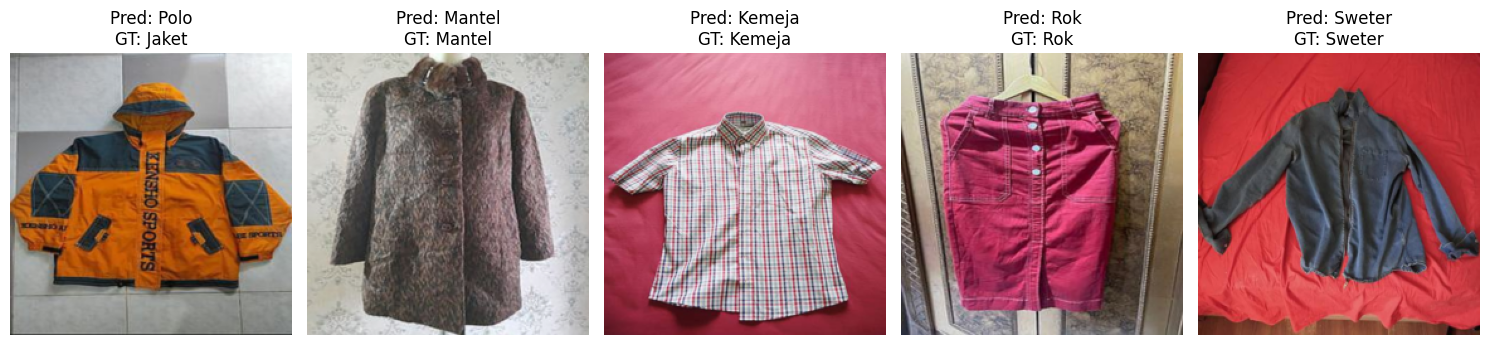

In [35]:
mostrar_predicciones(modelo_cargado, dl_test.dataset, clases_detectadas, cantidad=5)
